【手机信号数据集】解题报告

#### 数据预处理
1. 缺失值处理
    * 共尝试两种做法：
    * 缺失的RSSI、Latitude、Longitude 用0填充。
    * 缺失的RSSI、Latitude、Longitude 用主基站的相应值填充，最终用7个基站的数据进行训练。
2. 特征选择
    * 7个基站的AsuLevel,SignalLevel等特征影响不大
    * 训练集包含特征：7对经纬度、7个RSSI、Num_connected
    

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.core.display as di;
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

#### a
用指定的7个分类器来训练MR测试数据，预测GPS经纬度位置所在栅格，将预测的栅格中心位置作为该MR记录的预测位置。

metric:
* top10 grid上的precision，recall和f-measurement
* 距离误差（预测位置和证实位置的误差）的中位值

训练过程：
* 随机选取80%的数据记录作为训练集，余下20%作为测试集合
* 重复10次训练集/测试集的选择和误差计算，求取平均误差

以下为分类器的训练结果：



In [8]:
statics = pd.read_csv('../data/output/1452983_1i_statics.txt')
statics

,F,Median Error,Name,Overall Precision,Precision,Recall,Time
0,0.022156,472.565564,GradientBoostingClassifier,0.021557,0.011632,0.283474,549.486231
1,0.132942,407.262510,AdaBoostClassifier,0.071557,0.071557,0.966208,8.450424
2,0.455232,307.047519,KNeighborsClassifier,0.185902,0.404378,0.524247,0.282177
3,0.040545,259.025250,GaussianNB,0.110984,0.023172,0.251760,0.403399
4,0.809330,77.012485,DecisionTreeClassifier,0.355492,0.776233,0.846232,0.328057
5,0.816571,74.781151,BaggingClassifier,0.361148,0.782110,0.855846,0.783292
6,0.815736,68.699707,RandomForestClassifier,0.366557,0.780842,0.855099,0.606175


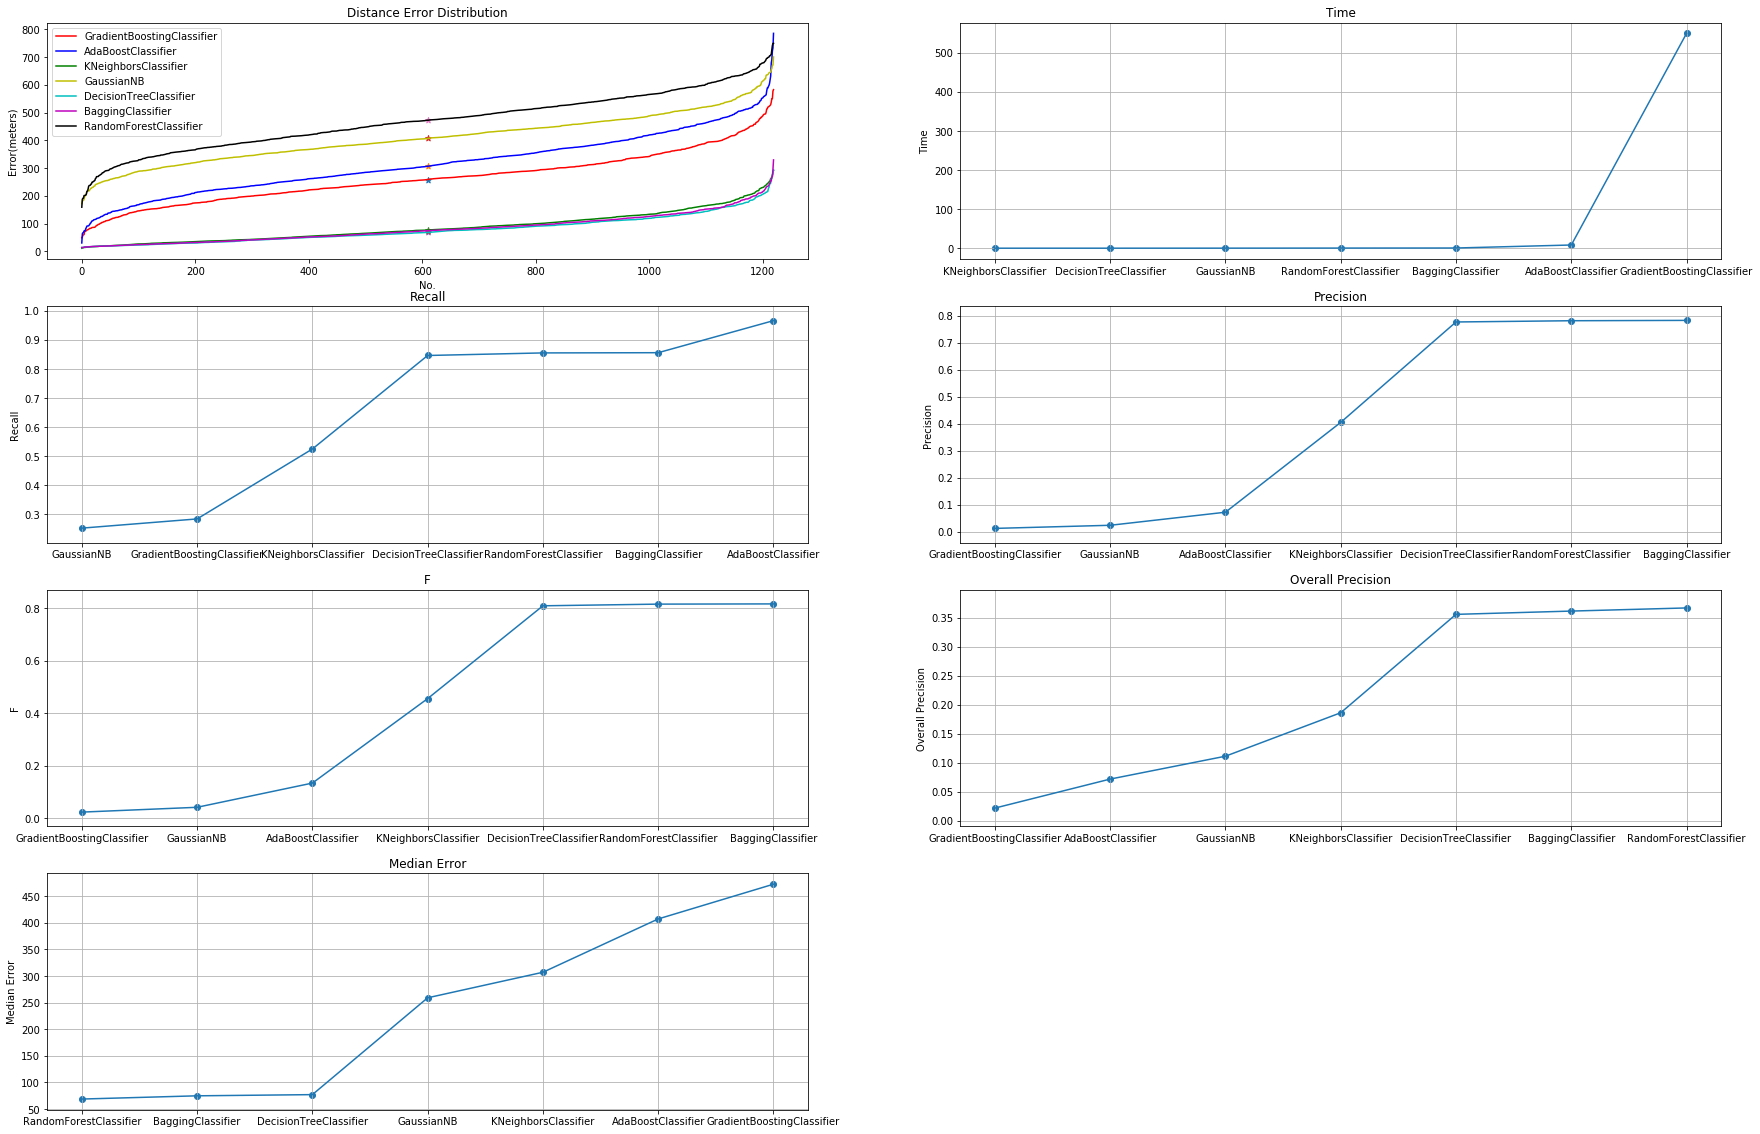

In [6]:
import a
a.plot()

图像解释：
1. 每个分类器在测试集上的距离误差图。
    * 综合性能从好到差排序：CART决策树、随机森林分类器、贝叶斯分类器、AdaBoost分类器、KNN、Bagging分类器
    * CART决策树、Bagging分类器的性能最好；Bagging分类器是对以CART决策树为基学习器的加权结合，性能好于单个CART决策树。
2. 每个分类器花费的时间。
    * 训练时间从短到长：KNN、CART决策树、贝叶斯分类器、随机森林分类器、Bagging分类器、AdaBoost分类器、GBDT分类器
    * GBDT分类器的训练时间肉眼可见地慢
    * 几种集成学习的分类器的训练建普遍长于其他分类器。
3. 每个分类器在top10 grid label上的查全率
    * AdaBoost分类器的查全率最高，CART决策树、Bagging分类器、随机森林分类器次之
    * 查全率从低到高：贝叶斯分类器、GBDT分类器、KNN、CART决策树、随机森林分类器、Bagging分类器、AdaBoost分类器
4. 每个分类器在top10 grid label上的准确率
    * CART决策树、Bagging分类器、随机森林分类器的准确率最优
5. 每个分类器在top10 grid label上的F值
    * CART决策树、Bagging分类器、随机森林分类器的F值最优
6. 每个分类器在overall grid label上的准确率
    * grid label过多， 预测的准确率普遍较低。本题更关键的指标是距离误差，而不是overall precision。
7. 每个分类器在测试集上的中位误差图。
    * CART决策树、Bagging分类器、随机森林分类器的中位误差最小

由于GBDT分类器训练时间太长，所以n_estimators设为10，在上图中性能较差。

综上，CART决策树、Bagging分类器、随机森林分类器三个分类器的性能最好，可以重点对这三个分类器进行参数调节和其他优化。


#### c & d & e
* c. 按照每个MR记录对应的主基站对MR记录进行分组，计算每个分组的MR记录的相对位置，分组用随机森林预测相对位置。
* d. 在c的基础上，对每个分组定位模型的中位误差进行排序，取中位误差最小的前top-k分组（记为topk+）和中位误差最大的后top-k分组，将topk+分组中的MR数据融入到topk-分组中，重新训练。
    *  尝试将topk+的数据全部归入每个top-分组后训练。
* e. 尝试构建MR分组之间的相似性，为topk-分组选择k个最相似的其他MR分组，将这些相似MR分组记录融入到topk-分组中，重新训练。
    * 用KMeans对MR分组聚类为k类，将每个topk-分组的MR记录所属的类别的所有样本并入该topk-分组后，重新训练。
    * 可以观察到，此时某些topk-分组的中位误差降低。
    
    
a中通过预测栅格标签，再将栅格位置转化为经纬度位置，偏差较大。

c中根据主基站分组，每个分组中的数据相似性更高，直接预测相对经纬度的位置标签，不需要经过栅格划分和栅格-经纬度转换。通过分组预测，大大降低距离偏差。

d中并入每个topk-分组的数据是相同的top+的数据，没有对并入每个topk-分组的数据作区分。

e相比d，先通过聚类，找到与每个top-分组属于同一类别的其他分组，将其他分组的数据并入该topk-分组，重新训练。


In [3]:
from c import plot_median_errors, plot
from d import plot_median_errors_comparison
import params

c . 距离误差分布


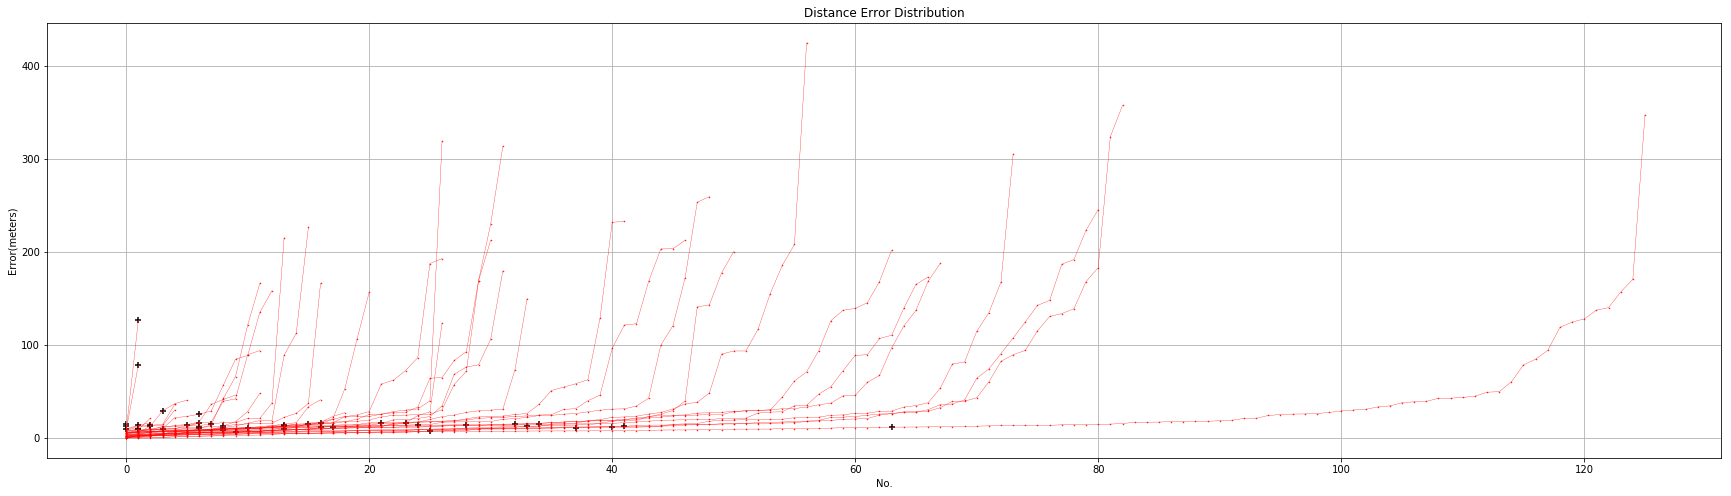

d . 距离误差分布


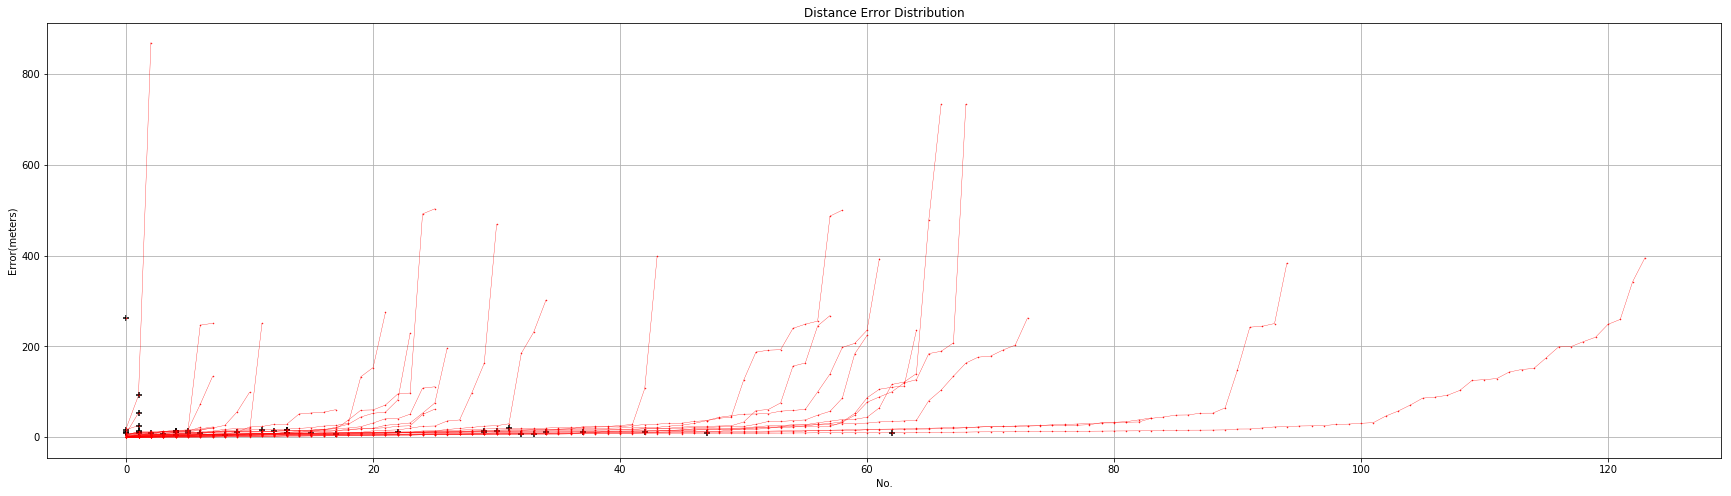

e . 距离误差分布


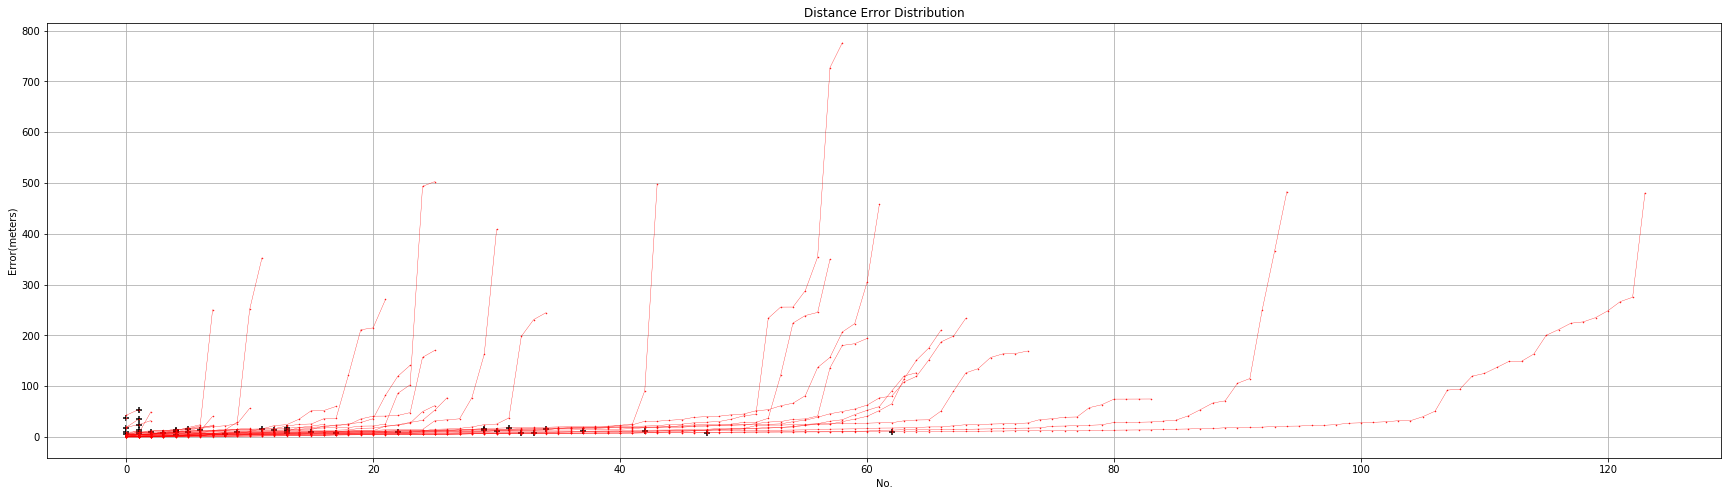

c . 中位误差分布


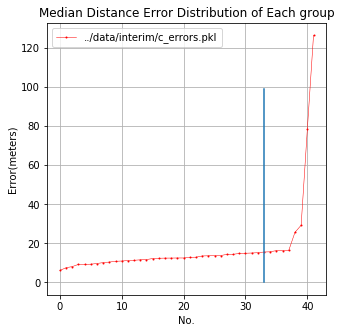

d . 中位误差分布


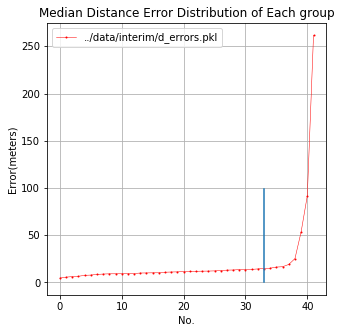

e . 中位误差分布


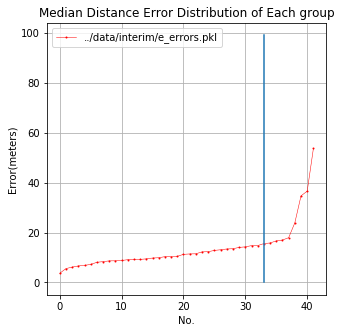

c&d&e 距离误差分布对比图


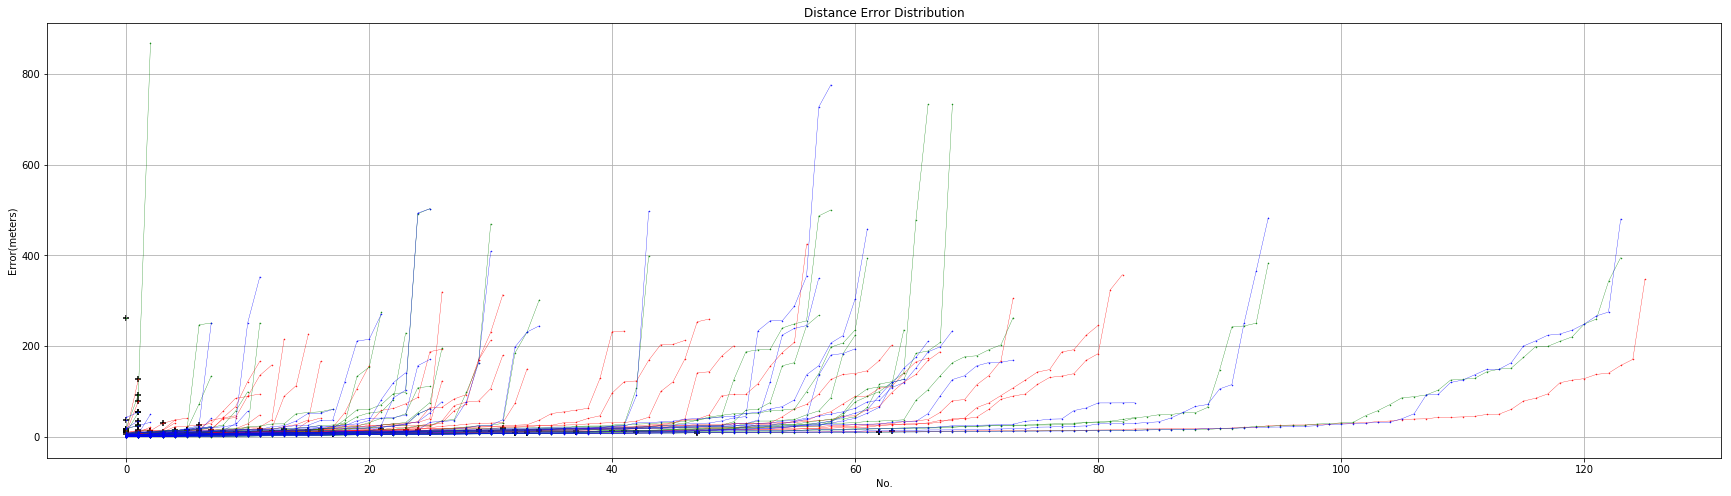

c&d&e 中位误差分布对比图


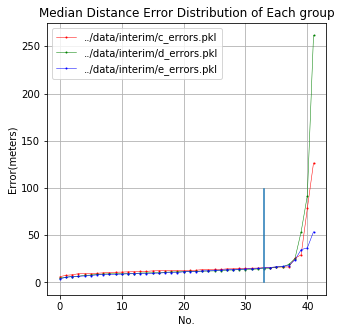

In [4]:
colors = ['r', 'g', 'b', 'm', 'y']
files = [params.c_errors_pkl, params.d_errors_pkl, params.e_errors_pkl]
for file in files:
    print(file.split('_')[0][-1], '. 距离误差分布')
    plot(file=[file])

for file in files:
    print(file.split('_')[0][-1], '. 中位误差分布')
    plot_median_errors_comparison(file=[file])
    
print('c&d&e 距离误差分布对比图')
plot(file=files)
print('c&d&e 中位误差分布对比图')
plot_median_errors_comparison(file=files)

从上图，
topk-分组并入所有top+数据后，某些分组中位误差升高。
topk-分组并入聚类后属于同一类别的数据后，中位误差明显降低。